In [1]:
!pip install --quiet transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [2]:
!pip install --quiet seqeval evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.2 MB/s eta 0:00:00


In [3]:
!pip install --quiet accelerate -U
!pip install --quiet transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.0 MB/s eta 0:00:00


# Main NLP Tasks

# 1. Summarization

In this section we’ll take a look at how Transformer models can be used to condense long documents into summaries, a task known as text summarization. This is one of the most challenging NLP tasks as it requires a range of abilities, such as understanding long passages and generating coherent text that captures the main topics in a document. However, when done well, text summarization is a powerful tool that can speed up various business processes by relieving the burden of domain experts to read long documents in detail.

**Preparing a multilingual corpus**

We’ll use the Multilingual Amazon Reviews Corpus to create our bilingual summarizer. This corpus consists of Amazon product reviews in six languages and is typically used to benchmark multilingual classifiers. However, since each review is accompanied by a short title, we can use the titles as the target summaries for our model to learn from! To get started, let’s download the English and Spanish subsets from the Hugging Face Hub:



In [14]:
from datasets import load_dataset

import pandas as pd
from datasets import Dataset, DatasetDict

In [15]:
train_csv_path = "/content/train.csv"
validation_csv_path = "/content/validation.csv"
test_csv_path = '/content/test.csv'

In [19]:
import os

print(os.getcwd())

/content


In [23]:
train_df = pd.read_csv(train_csv_path, engine='python', encoding="utf-8", error_bad_lines=False)
validation_df = pd.read_csv(validation_csv_path, engine='python', encoding="latin1")
test_df = pd.read_csv(test_csv_path, engine='python', encoding="latin1")

TypeError: read_csv() got an unexpected keyword argument 'error_bad_lines'

In [ ]:
spanish_train_df = train_df[train_df['language'] == 'es']
spanish_validation_df = validation_df[validation_df['language'] == 'es']
spanish_test_df = test_df[test_df['language'] == 'es']

english_train_df = train_df[train_df['language'] == 'en']
english_validation_df = validation_df[validation_df['language'] == 'en']
english_test_df = test_df[test_df['language'] == 'en']

In [ ]:
spanish_dataset = DatasetDict({
'train': Dataset.from_pandas(spanish_train_df),
'validation': Dataset.from_pandas(spanish_validation_df),
'test': Dataset.from_pandas(spanish_test_df)
})

english_dataset = DatasetDict({
'train': Dataset.from_pandas(english_train_df),
'validation': Dataset.from_pandas(english_validation_df),
'test': Dataset.from_pandas(english_test_df)
})
english_dataset = english_dataset.remove_columns(['Unnamed: 0', 'index_level_0'])
spanish_dataset = spanish_dataset.remove_columns(['Unnamed: 0', 'index_level_0'])`

As you can see, for each language there are 200,000 reviews for the train split, and 5,000 reviews for each of the validation and test splits. The review information we are interested in is contained in the review_body and review_title columns. Let’s take a look at a few examples by creating a simple function that takes a random sample from the training set:



In [ ]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


show_samples(english_dataset)

✏️ Try it out! Change the random seed in the Dataset.shuffle() command to explore other reviews in the corpus. If you’re a Spanish speaker, take a look at some of the reviews in spanish_dataset to see if the titles also seem like reasonable summaries.

This sample shows the diversity of reviews one typically finds online, ranging from positive to negative (and everything in between!). Although the example with the “meh” title is not very informative, the other titles look like decent summaries of the reviews themselves. Training a summarization model on all 400,000 reviews would take far too long on a single GPU, so instead we’ll focus on generating summaries for a single domain of products. To get a feel for what domains we can choose from, let’s convert english_dataset to a pandas.DataFrame and compute the number of reviews per product category:

In [ ]:
english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["product_category"].value_counts()[:20]

The most popular products in the English dataset are about household items, clothing, and wireless electronics. To stick with the Amazon theme, though, let’s focus on summarizing book reviews — after all, this is what the company was founded on! We can see two product categories that fit the bill (book and digital_ebook_purchase), so let’s filter the datasets in both languages for just these products. As we saw in Chapter 5, the Dataset.filter() function allows us to slice a dataset very efficiently, so we can define a simple function to do this:



In [ ]:
def filter_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )

Now when we apply this function to english_dataset and spanish_dataset, the result will contain just those rows involving the book categories. Before applying the filter, let’s switch the format of english_dataset from "pandas" back to "arrow":



In [ ]:
english_dataset.reset_format()

We can then apply the filter function, and as a sanity check let’s inspect a sample of reviews to see if they are indeed about books:



In [ ]:
spanish_books = spanish_dataset.filter(filter_books)
english_books = english_dataset.filter(filter_books)
show_samples(english_books)

Okay, we can see that the reviews are not strictly about books and might refer to things like calendars and electronic applications such as OneNote. Nevertheless, the domain seems about right to train a summarization model on. Before we look at various models that are suitable for this task, we have one last bit of data preparation to do: combining the English and Spanish reviews as a single DatasetDict object. 🤗 Datasets provides a handy concatenate_datasets() function that (as the name suggests) will stack two Dataset objects on top of each other. So, to create our bilingual dataset, we’ll loop over each split, concatenate the datasets for that split, and shuffle the result to ensure our model doesn’t overfit to a single language:



In [ ]:
from datasets import concatenate_datasets, DatasetDict

books_dataset = DatasetDict()

for split in english_books.keys():
    books_dataset[split] = concatenate_datasets(
        [english_books[split], spanish_books[split]]
    )
    books_dataset[split] = books_dataset[split].shuffle(seed=42)

# Peek at a few examples
show_samples(books_dataset)

This certainly looks like a mix of English and Spanish reviews! Now that we have a training corpus, one final thing to check is the distribution of words in the reviews and their titles. This is especially important for summarization tasks, where short reference summaries in the data can bias the model to only output one or two words in the generated summaries. The plots below show the word distributions, and we can see that the titles are heavily skewed toward just 1-2 words:

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter7/review-lengths-dark.svg)


To deal with this, we’ll filter out the examples with very short titles so that our model can produce more interesting summaries. Since we’re dealing with English and Spanish texts, we can use a rough heuristic to split the titles on whitespace and then use our trusty Dataset.filter() method as follows:



In [ ]:
books_dataset = books_dataset.filter(lambda x: len(x["review_title"].split()) > 2)

Now that we’ve prepared our corpus, let’s take a look at a few possible Transformer models that one might fine-tune on it!



**Models for text summarization**

If you think about it, text summarization is a similar sort of task to machine translation: we have a body of text like a review that we’d like to “translate” into a shorter version that captures the salient features of the input. Accordingly, most Transformer models for summarization adopt the encoder-decoder architecture that we first encountered, although there are some exceptions like the GPT family of models which can also be used for summarization in few-shot settings. The following table lists some popular pretrained models that can be fine-tuned for summarization.

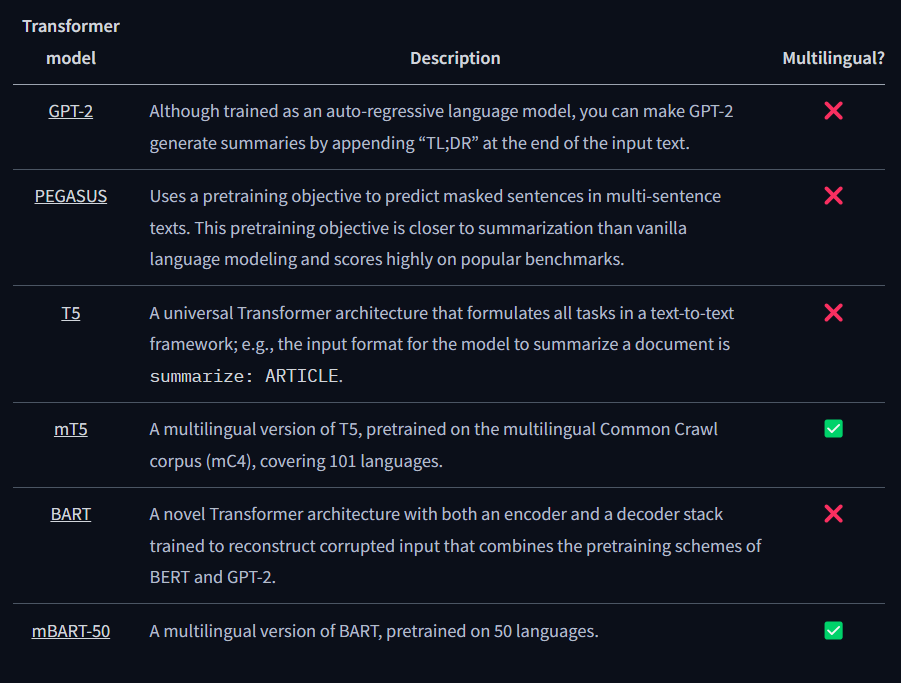

As you can see from this table, the majority of Transformer models for summarization (and indeed most NLP tasks) are monolingual. This is great if your task is in a “high-resource” language like English or German, but less so for the thousands of other languages in use across the world. Fortunately, there is a class of multilingual Transformer models, like mT5 and mBART, that come to the rescue. These models are pretrained using language modeling, but with a twist: instead of training on a corpus of one language, they are trained jointly on texts in over 50 languages at once!

We’ll focus on mT5, an interesting architecture based on T5 that was pretrained in a text-to-text framework. In T5, every NLP task is formulated in terms of a prompt prefix like summarize: which conditions the model to adapt the generated text to the prompt. As shown in the figure below, this makes T5 extremely versatile, as you can solve many tasks with a single model!

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter7/t5-dark.svg)

mT5 doesn’t use prefixes, but shares much of the versatility of T5 and has the advantage of being multilingual. Now that we’ve picked a model, let’s take a look at preparing our data for training.

✏️ Try it out! Once you’ve worked through this section, see how well mT5 compares to mBART by fine-tuning the latter with the same techniques. For bonus points, you can also try fine-tuning T5 on just the English reviews. Since T5 has a special prefix prompt, you’ll need to prepend summarize: to the input examples in the preprocessing steps below.

**Preprocessing the data**

Our next task is to tokenize and encode our reviews and their titles. As usual, we begin by loading the tokenizer associated with the pretrained model checkpoint. We’ll use mt5-small as our checkpoint so we can fine-tune the model in a reasonable amount of time:



In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

💡 In the early stages of your NLP projects, a good practice is to train a class of “small” models on a small sample of data. This allows you to debug and iterate faster toward an end-to-end workflow. Once you are confident in the results, you can always scale up the model by simply changing the model checkpoint!

Let’s test out the mT5 tokenizer on a small example:

In [ ]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

Here we can see the familiar input_ids and attention_mask that we encountered in our first fine-tuning experiments. Let’s decode these input IDs with the tokenizer’s convert_ids_to_tokens() function to see what kind of tokenizer we’re dealing with:



In [ ]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

The special Unicode character ▁ and end-of-sequence token </s> indicate that we’re dealing with the SentencePiece tokenizer, which is based on the Unigram segmentation algorithm. Unigram is especially useful for multilingual corpora since it allows SentencePiece to be agnostic about accents, punctuation, and the fact that many languages, like Japanese, do not have whitespace characters.

To tokenize our corpus, we have to deal with a subtlety associated with summarization: because our labels are also text, it is possible that they exceed the model’s maximum context size. This means we need to apply truncation to both the reviews and their titles to ensure we don’t pass excessively long inputs to our model. The tokenizers in 🤗 Transformers provide a nifty text_target argument that allows you to tokenize the labels in parallel to the inputs. Here is an example of how the inputs and targets are processed for mT5:

In [ ]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Let’s walk through this code to understand what’s happening. The first thing we’ve done is define values for max_input_length and max_target_length, which set the upper limits for how long our reviews and titles can be. Since the review body is typically much larger than the title, we’ve scaled these values accordingly.

With preprocess_function(), it is then a simple matter to tokenize the whole corpus using the handy Dataset.map() function we’ve used extensively throughout this course:

In [ ]:
tokenized_datasets = books_dataset.map(preprocess_function, batched=True)

Now that the corpus has been preprocessed, let’s take a look at some metrics that are commonly used for summarization. As we’ll see, there is no silver bullet when it comes to measuring the quality of machine-generated text.

💡 You may have noticed that we used batched=True in our Dataset.map() function above. This encodes the examples in batches of 1,000 (the default) and allows you to make use of the multithreading capabilities of the fast tokenizers in 🤗 Transformers. Where possible, try using batched=True to get the most out of your preprocessing!

**Metrics for text summarization**

Measuring performance for text generation tasks like summarization or translation is complex due to multiple valid outputs for the same input, making exact matches ineffective. The commonly used ROUGE score addresses this by comparing a generated summary against human-created reference summaries, allowing for variations in wording and phrasing.

In [ ]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

To compare summaries, a basic method is to count overlapping words, but this is crude. Instead, ROUGE uses precision and recall scores.

Recall measures how much of the reference summary is captured by the generated one. It can be calculated as:

$ \text{Recall} = \frac{\text{Number of overlapping words}}{\text{Total number of words in reference summary}} $

For example, if the reference summary has 6 words and all 6 are in the generated summary, the recall is 1 (6/6). However, if the generated summary is verbose, it may still have a high recall but be less useful.

Precision measures how much of the generated summary is relevant:

$ \text{Precision} = \frac{\text{Number of overlapping words}}{\text{Total number of words in generated summary}} $

For instance, if a verbose generated summary has 10 words and 6 overlap with the reference, the precision is 0.6 (6/10). A shorter, more relevant summary might have a higher precision, such as 0.86 (6/7).

Both precision and recall are typically computed, and the F1-score, the harmonic mean of precision and recall, is reported. This can be done easily in 🤗 Datasets by installing the `rouge_score` package.

In [ ]:
!pip install --quiet rouge_score

In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

Whoa, there’s a lot of information in that output — what does it all mean? First, 🤗 Datasets actually computes confidence intervals for precision, recall, and F1-score; these are the low, mid, and high attributes you can see here. Moreover, 🤗 Datasets computes a variety of ROUGE scores which are based on different types of text granularity when comparing the generated and reference summaries. The rouge1 variant is the overlap of unigrams — this is just a fancy way of saying the overlap of words and is exactly the metric we’ve discussed above. To verify this, let’s pull out the mid value of our scores:



In [ ]:
scores["rouge1"].mid

Great, the precision and recall numbers match up! Now what about those other ROUGE scores? rouge2 measures the overlap between bigrams (think the overlap of pairs of words), while rougeL and rougeLsum measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries. The “sum” in rougeLsum refers to the fact that this metric is computed over a whole summary, while rougeL is computed as the average over individual sentences.

✏️ Try it out! Create your own example of a generated and reference summary and see if the resulting ROUGE scores agree with a manual calculation based on the formulas for precision and recall. For bonus points, split the text into bigrams and compare the precision and recall for the rouge2 metric.

We’ll use these ROUGE scores to track the performance of our model, but before doing that let’s do something every good NLP practitioner should do: create a strong, yet simple baseline!

**Creating a strong baseline**

A common baseline for text summarization is to simply take the first three sentences of an article, often called the lead-3 baseline. We could use full stops to track the sentence boundaries, but this will fail on acronyms like “U.S.” or “U.N.” — so instead we’ll use the nltk library, which includes a better algorithm to handle these cases. You can install the package using pip as follows:

In [ ]:
!pip install --quiet nltk

In [ ]:
import nltk

nltk.download("punkt")

Next, we import the sentence tokenizer from nltk and create a simple function to extract the first three sentences in a review. The convention in text summarization is to separate each summary with a newline, so let’s also include this and test it on a training example:



In [ ]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(books_dataset["train"][1]["review_body"]))

This seems to work, so let’s now implement a function that extracts these “summaries” from a dataset and computes the ROUGE scores for the baseline:



In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

We can then use this function to compute the ROUGE scores over the validation set and prettify them a bit using Pandas:



In [ ]:
import pandas as pd

score = evaluate_baseline(books_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

We can see that the rouge2 score is significantly lower than the rest; this likely reflects the fact that review titles are typically concise and so the lead-3 baseline is too verbose. Now that we have a good baseline to work from, let’s turn our attention toward fine-tuning mT5!



**Fine-tuning mT5 witth the Trainer API**

Fine-tuning a model for summarization is very similar to the other tasks we’ve covered in this chapter. The first thing we need to do is load the pretrained model from the mt5-small checkpoint. Since summarization is a sequence-to-sequence task, we can load the model with the AutoModelForSeq2SeqLM class, which will automatically download and cache the weights:



In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

💡 If you’re wondering why you don’t see any warnings about fine-tuning the model on a downstream task, that’s because for sequence-to-sequence tasks we keep all the weights of the network. Compare this to our text classification model in Chapter 3, where the head of the pretrained model was replaced with a randomly initialized network.

The next thing we need to do is log in to the Hugging Face Hub. If you’re running this code in a notebook, you can do so with the following utility function:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

We’ll need to generate summaries in order to compute ROUGE scores during training. Fortunately, 🤗 Transformers provides dedicated Seq2SeqTrainingArguments and Seq2SeqTrainer classes that can do this for us automatically! To see how this works, let’s first define the hyperparameters and other arguments for our experiments:

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-amazon-en-es",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In this setup, the `predict_with_generate` argument is enabled to generate summaries during evaluation for computing ROUGE scores each epoch. The `generate()` method of the model is used for this purpose, predicting tokens one by one. Hyperparameters like learning rate, number of epochs, and weight decay have been adjusted, and `save_total_limit` is set to save only up to 3 checkpoints to conserve disk space. The `push_to_hub=True` argument allows the model to be pushed to the Hub after training, with the repository location defined by `output_dir` and optionally specified by `hub_model_id`.

A `compute_metrics()` function is provided to evaluate the model during training. For summarization, this involves decoding outputs and labels into text before computing ROUGE scores. The function also uses `sent_tokenize()` from nltk to separate summary sentences with newlines.

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

Next, we need to define a data collator for our sequence-to-sequence task. Since mT5 is an encoder-decoder Transformer model, one subtlety with preparing our batches is that during decoding we need to shift the labels to the right by one. This is required to ensure that the decoder only sees the previous ground truth labels and not the current or future ones, which would be easy for the model to memorize. This is similar to how masked self-attention is applied to the inputs in a task like causal language modeling.

Luckily, 🤗 Transformers provides a DataCollatorForSeq2Seq collator that will dynamically pad the inputs and the labels for us. To instantiate this collator, we simply need to provide the tokenizer and model:

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Let’s see what this collator produces when fed a small batch of examples. First, we need to remove the columns with strings because the collator won’t know how to pad these elements:



In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(
    books_dataset["train"].column_names
)

Since the collator expects a list of dicts, where each dict represents a single example in the dataset, we also need to wrangle the data into the expected format before passing it to the data collator:



In [ ]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

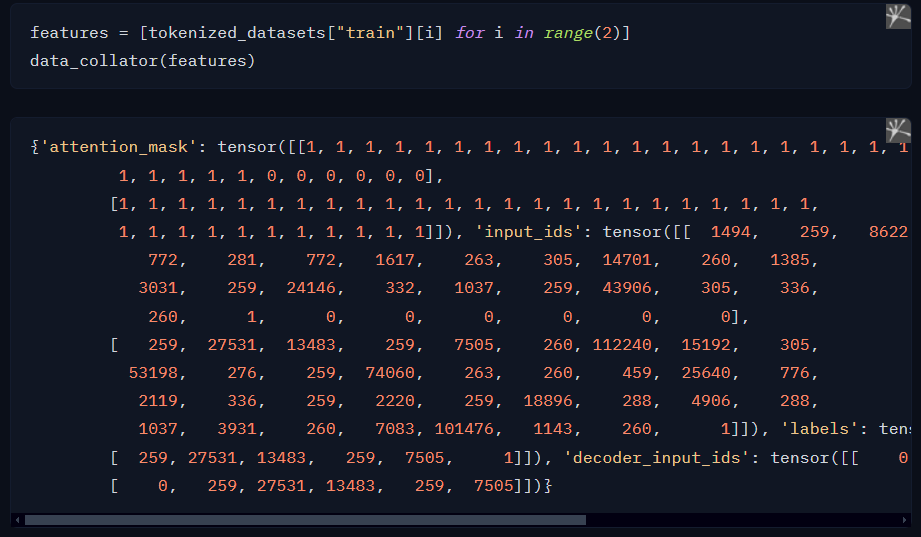

The main thing to notice here is that the first example is longer than the second one, so the input_ids and attention_mask of the second example have been padded on the right with a [PAD] token (whose ID is 0). Similarly, we can see that the labels have been padded with -100s, to make sure the padding tokens are ignored by the loss function. And finally, we can see a new decoder_input_ids which has shifted the labels to the right by inserting a [PAD] token in the first entry.

We finally have all the ingredients we need to train with! We now simply need to instantiate the trainer with the standard arguments:

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

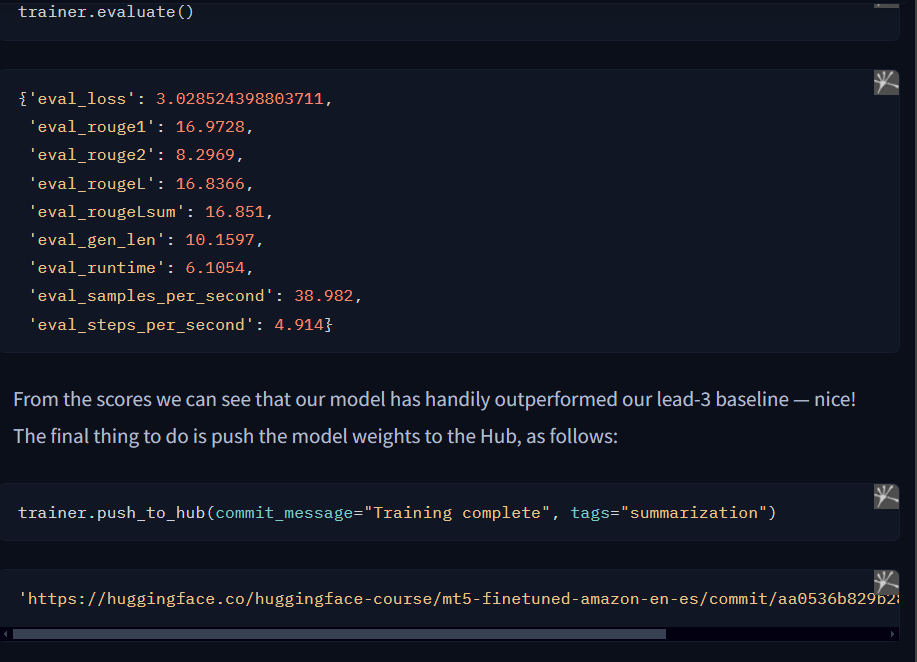

**Fine-Tuning mT5 with 🤗 Accelerate**

**Preparing everything for training**


The first thing we need to do is create a DataLoader for each of our splits. Since the PyTorch dataloaders expect batches of tensors, we need to set the format to "torch" in our datasets:



In [ ]:
tokenized_datasets.set_format("torch")

Now that we’ve got datasets consisting of just tensors, the next thing to do is instantiate the DataCollatorForSeq2Seq again. For this we need to provide a fresh version of the model, so let’s load it again from our cache:



In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=batch_size
)

The next thing to do is define the optimizer we want to use. As in our other examples, we’ll use AdamW, which works well for most problems:



In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

🚨 If you’re training on a TPU, you’ll need to move all the code above into a dedicated training function. See Chapter 3 for more details.

Now that we’ve prepared our objects, there are three remaining things to do:

- Define the learning rate schedule.
- Implement a function to post-process the summaries for evaluation.
- Create a repository on the Hub that we can push our model to.

For the learning rate schedule, we’ll use the standard linear one from previous sections:

In [ ]:
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

For post-processing, we need a function that splits the generated summaries into sentences that are separated by newlines. This is the format the ROUGE metric expects, and we can achieve this with the following snippet of code:



In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

This should look familiar to you if you recall how we defined the compute_metrics() function of the Seq2SeqTrainer.

Finally, we need to create a model repository on the Hugging Face Hub. For this, we can use the appropriately titled 🤗 Hub library. We just need to define a name for our repository, and the library has a utility function to combine the repository ID with the user profile:

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "test-bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

Now we can use this repository name to clone a local version to our results directory that will store the training artifacts:



In [ ]:
from huggingface_hub import Repository

output_dir = "results-mt5-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

**Training loop**

The training loop for summarization is quite similar to the other 🤗 Accelerate examples that we’ve encountered and is roughly split into four main steps:

1. Train the model by iterating over all the examples in train_dataloader for each epoch.
2. Generate model summaries at the end of each epoch, by first generating the tokens and then decoding them (and the reference summaries) into text.
3. Compute the ROUGE scores using the same techniques we saw earlier.
4. Save the checkpoints and push everything to the Hub. Here we rely on the nifty blocking=False argument of the Repository object so that we can push the checkpoints per epoch asynchronously. This allows us to continue training without having to wait for the somewhat slow upload associated with a GB-sized model!

These steps can be seen in the following block of code:

In [ ]:
from tqdm.auto import tqdm
import torch
import numpy as np

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # If we did not pad to max length, we need to pad the labels too
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = rouge_score.compute()
    # Extract the median ROUGE scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch}:", result)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

**Use fine-tuned model**

In [27]:
from transformers import pipeline

hub_model_id = "huggingface-course/mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=hub_model_id)

config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.33M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
def print_summary(idx):
    review = books_dataset["test"][idx]["review_body"]
    title = books_dataset["test"][idx]["review_title"]
    summary = summarizer(books_dataset["test"][idx]["review_body"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

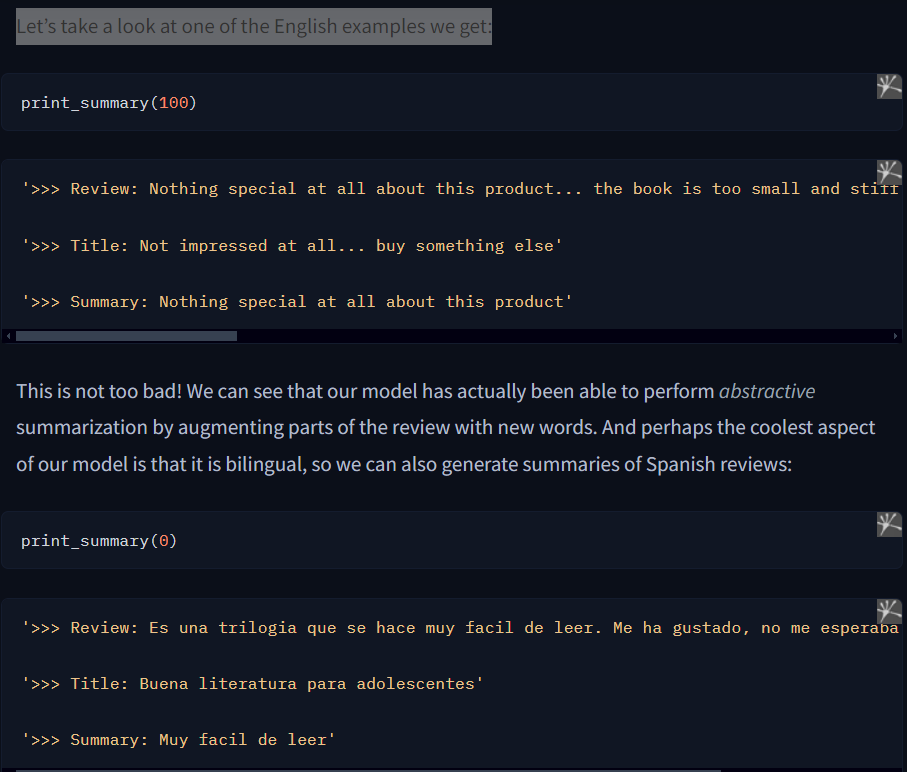

# 2. Training a causal language model from scratch

**Gathering the data**

The Transformers textbook utilized Python code from GitHub repositories to create a dataset for training a large GPT-2 model. They used a GitHub dump named codeparrot, containing around 20 million Python files totaling 180 GB, which they shared on the Hugging Face Hub. Due to the massive size of the dataset, training on the entire corpus is resource-intensive. To focus only on the Python data science stack, they filtered the codeparrot dataset using a streaming approach without downloading it. They employed a function to filter code samples containing specific libraries relevant to the data science stack.

In [28]:
def any_keyword_in_string(string, keywords):
    for keyword in keywords:
        if keyword in string:
            return True
    return False

In [29]:
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
example_1 = "import numpy as np"
example_2 = "import pandas as pd"

print(
    any_keyword_in_string(example_1, filters), any_keyword_in_string(example_2, filters)
)

False True


We can use this to create a function that will stream the dataset and filter the elements we want:



In [30]:
from collections import defaultdict
from tqdm import tqdm
from datasets import Dataset


def filter_streaming_dataset(dataset, filters):
    filtered_dict = defaultdict(list)
    total = 0
    for sample in tqdm(iter(dataset)):
        total += 1
        if any_keyword_in_string(sample["content"], filters):
            for k, v in sample.items():
                filtered_dict[k].append(v)
    print(f"{len(filtered_dict['content'])/total:.2%} of data after filtering.")
    return Dataset.from_dict(filtered_dict)

Then we can simply apply this function to the streaming dataset:



In [31]:
# This cell will take a very long time to execute, so you should skip it and go to
# the next one!
from datasets import load_dataset

split = "train"  # "valid"
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]

data = load_dataset(f"transformersbook/codeparrot-{split}", split=split, streaming=True)
filtered_data = filter_streaming_dataset(data, filters)

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

369844it [02:07, 2905.99it/s]


KeyboardInterrupt: 

This leaves us with about 3% of the original dataset, which is still quite sizable — the resulting dataset is 6 GB and consists of 600,000 Python scripts!

Filtering the full dataset can take 2-3h depending on your machine and bandwidth. If you don’t want to go through this lengthy process yourself, we provide the filtered dataset on the Hub for you to download:

In [32]:
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train,  # .shuffle().select(range(50000)),
        "valid": ds_valid,  # .shuffle().select(range(500))
    }
)

raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split:   0%|          | 0/3322 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 606720
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 3322
    })
})

> Pretraining the language model will take a while. We suggest that you first run the training loop on a sample of the data by uncommenting the two partial lines above, and make sure that the training successfully completes and the models are stored. Nothing is more frustrating than a training run failing at the last step because you forgot to create a folder or because there’s a typo at the end of the training loop!

Let’s look at an example from the dataset. We’ll just show the first 200 characters of each field:

In [33]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

REPO_NAME: kmike/scikit-learn
PATH: sklearn/utils/__init__.py
COPIES: 3
SIZE: 10094
CONTENT: """
The :mod:`sklearn.utils` module includes various utilites.
"""

from collections import Sequence

import numpy as np
from scipy.sparse import issparse
import warnings

from .murmurhash import murm
LICENSE: bsd-3-clause


We can see that the content field contains the code that we want our model to train on. Now that we have a dataset, we need to prepare the texts so they’re in a format suitable for pretraining.



**Preparing the dataset**

The process begins with tokenizing the data to prepare it for training, focusing on autocompleting short function calls. By limiting the context size to 128 tokens, training becomes faster and requires less memory. Adjusting this context size may be necessary depending on specific application needs, such as generating unit tests from function definitions, but this increases GPU memory usage. To handle documents longer than 128 tokens, the approach involves tokenizing the entire input and splitting it into chunks, discarding any smaller chunks to avoid unnecessary padding. This ensures optimal use of the dataset without sacrificing data volume.

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter7/chunking_texts-dark.svg)

In [34]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/789k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/448k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Input IDs length: 34
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 117, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 41]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The process involves analyzing two examples that yield a total of 34 segments. Notably, segments at the ends of both documents, containing fewer than 128 tokens (117 and 41 respectively), are deemed insignificant and can be discarded safely. The `overflow_to_sample_mapping` field aids in reconstructing which chunks originally belonged to each input sample.

The Dataset's `map()` function in 🤗 Datasets is advantageous because it allows batch operations that don't strictly require one-to-one mappings. This flexibility is particularly useful for tasks like data augmentation or filtering, where the number of elements in batches can vary. For instance, in tokenizing each element into chunks of specified sizes, multiple samples are generated from each document. To maintain consistency, any conflicting columns should be deleted before returning the modified data within the `Dataset.map()` call.

In [35]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/606720 [00:00<?, ? examples/s]

KeyboardInterrupt: 

We now have 16.7 million examples with 128 tokens each, which corresponds to about 2.1 billion tokens in total. For reference, OpenAI’s GPT-3 and Codex models are trained on 300 and 100 billion tokens, respectively, where the Codex models are initialized from the GPT-3 checkpoints. Our goal in this section is not to compete with these models, which can generate long, coherent texts, but to create a scaled-down version providing a quick autocomplete function for data scientists.

Now that we have the dataset ready, let’s set up the model!

✏️ Try it out! Getting rid of all the chunks that are smaller than the context size wasn’t a big issue here because we’re using small context windows. As you increase the context size (or if you have a corpus of short documents), the fraction of chunks that are thrown away will also grow. A more efficient way to prepare the data is to join all the tokenized samples in a batch with an eos_token_id token in between, and then perform the chunking on the concatenated sequences. As an exercise, modify the tokenize() function to make use of that approach. Note that you’ll want to set truncation=False and remove the other arguments from the tokenizer to get the full sequence of token IDs.

**Initializing a new model**

Our first step is to freshly initialize a GPT-2 model. We’ll use the same configuration for our model as for the small GPT-2 model, so we load the pretrained configuration, make sure that the tokenizer size matches the model vocabulary size and pass the bos and eos (beginning and end of sequence) token IDs:



In [36]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

With that configuration, we can load a new model. Note that this is the first time we don’t use the from_pretrained() function, since we’re actually initializing a model ourself:



In [37]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


Our model has 124M parameters that we’ll have to tune. Before we can start training, we need to set up a data collator that will take care of creating the batches. We can use the DataCollatorForLanguageModeling collator, which is designed specifically for language modeling (as the name subtly suggests). Besides stacking and padding batches, it also takes care of creating the language model labels — in causal language modeling the inputs serve as labels too (just shifted by one element), and this data collator creates them on the fly during training so we don’t need to duplicate the input_ids.

Note that DataCollatorForLanguageModeling supports both masked language modeling (MLM) and causal language modeling (CLM). By default it prepares data for MLM, but we can switch to CLM by setting the argument mlm=False:

In [38]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

example:

In [ ]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

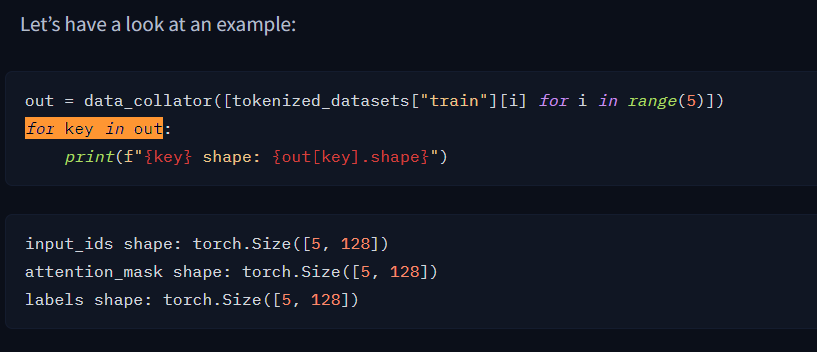

We can see that the examples have been stacked and all the tensors have the same shape.

⚠️ Shifting the inputs and labels to align them happens inside the model, so the data collator just copies the inputs to create the labels.

Now we have everything in place to actually train our model — that wasn’t so much work after all! Before we start training we should log in to Hugging Face. If you’re working in a notebook, you can do so with the following utility function:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

All that’s left to do is configure the training arguments and fire up the Trainer. We’ll use a cosine learning rate schedule with some warmup and an effective batch size of 256 (per_device_train_batch_size * gradient_accumulation_steps). Gradient accumulation is used when a single batch does not fit into memory, and incrementally builds up the gradient through several forward/backward passes. We’ll see this in action when we create the training loop with 🤗 Accelerate.

In [ ]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="codeparrot-ds",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

Now we can just start the Trainer and wait for training to finish. Depending on whether you run it on the full or a subset of the training set this will take 20 or 2 hours, respectively, so grab a few coffees and a good book to read!



In [ ]:
trainer.train()

After training completes, we can push the model and tokenizer to the Hub:



In [ ]:
trainer.push_to_hub()

✏️ Try it out! It only took us about 30 lines of code in addition to the TrainingArguments to get from raw texts to training GPT-2. Try it out with your own dataset and see if you can get good results!

💡 If you have access to a machine with multiple GPUs, try to run the code there. The Trainer automatically manages multiple machines, and this can speed up training tremendously.

**Code generation with a pipeline**

Now is the moment of truth: let’s see how well the trained model actually works! We can see in the logs that the loss went down steadily, but to put the model to the test let’s take a look at how well it works on some prompts. To do that we’ll wrap the model in a text generation pipeline, and we’ll put it on the GPU for fast generations if there is one available:



In [39]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline(
    "text-generation", model="huggingface-course/codeparrot-ds", device=device
)

config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/789k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/448k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Let’s start with the simple task of creating a scatter plot:



In [40]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
# ax labels will appear on bottom
plt.xlabel("PC


The result looks correct. Does it also work for a pandas operation? Let’s see if we can create a DataFrame from two arrays:



In [41]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
data = sm.datasets.wealth.load_pandas().data


Nice, that’s the correct answer — although it then inserts the column x again. Since the number of generated tokens is limited, the following for loop is cut off. Let’s see if we can do something a bit more complex and have the model help us use the groupby operation:



In [43]:
txt = """\
# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession
df.mean(axis


Not bad; that’s the right way to do it. Finally, let’s see if we can also use it for scikit-learn and set up a Random Forest model:



In [45]:
txt = """
# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:
rng = np.random.RandomState(1)
forest = ensemble.


Looking at these few examples, it seems that the model has learned some of the syntax of the Python data science stack (of course, we would need to evaluate it more thoroughly before deploying the model in the real world). Sometimes it requires more customization of the model training to achieve the necessary performance for a given use case, however. For example, what if we would like to dynamically update the batch size or have a conditional training loop that skips bad examples on the fly? One option would be to subclass the Trainer and add the necessary changes, but sometimes it’s simpler to write the training loop from scratch. That’s where 🤗 Accelerate comes in.

**Training with 🤗 Accelerate**

We’ve seen how to train a model with the Trainer, which can allow for some customization. However, sometimes we want full control over the training loop, or we want to make some exotic changes. In this case 🤗 Accelerate is a great choice, and in this section we’ll go through the steps to use it to train our model. To make things more interesting, we’ll also add a twist to the training loop.

Since we are mainly interested in sensible autocompletion for the the data science libraries, it makes sense to give more weight to training samples that make more use of these libraries. We can easily identify these examples through the use of keywords such as plt, pd, sk, fit, and predict, which are the most frequent import names for matplotlib.pyplot, pandas, and sklearn as well as the fit/predict pattern of the latter. If these are each represented as a single token, we can easily check if they occur in the input sequence. Tokens can have a whitespace prefix, so we’ll also check for those versions in the tokenizer vocabulary. To verify that it works, we’ll add one test token which should be split into multiple tokens:





In [46]:
keytoken_ids = []
for keyword in [
    "plt",
    "pd",
    "sk",
    "fit",
    "predict",
    " plt",
    " pd",
    " sk",
    " fit",
    " predict",
    "testtest",
]:
    ids = tokenizer([keyword]).input_ids[0]
    if len(ids) == 1:
        keytoken_ids.append(ids[0])
    else:
        print(f"Keyword has not single token: {keyword}")

Keyword has not single token: testtest


Great, that seems to work nicely! We can now write a custom loss function that takes the input sequence, the logits, and the key tokens we just selected as inputs. First we need to align the logits and inputs: the input sequence shifted by one to the right forms the labels, since the next token is the label for the current token. We can achieve this by starting the labels from the second token of the input sequence, since the model does not make a prediction for the first token anyway. Then we cut off the last logit, as we don’t have a label for the token that follows the full input sequence. With that we can compute the loss per sample and count the occurrences of all keywords in each sample. Finally, we calculate the weighted average over all samples using the occurrences as weights. Since we don’t want to throw away all the samples that have no keywords, we add 1 to the weights:



In [47]:
from torch.nn import CrossEntropyLoss
import torch


def keytoken_weighted_loss(inputs, logits, keytoken_ids, alpha=1.0):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)
    # Calculate and scale weighting
    weights = torch.stack([(inputs == kt).float() for kt in keytoken_ids]).sum(
        axis=[0, 2]
    )
    weights = alpha * (1.0 + weights)
    # Calculate weighted average
    weighted_loss = (loss_per_sample * weights).mean()
    return weighted_loss

Before we can start training with this awesome new loss function, we need to prepare a few things:

- We need dataloaders to load the data in batches.
- We need to set up weight decay parameters.
- From time to time we want to evaluate, so it makes sense to wrap the evaluation code in a function.

Let’s start with the dataloaders. We only need to set the dataset’s format to "torch", and then we can pass it to a PyTorch DataLoader with the appropriate batch size:

In [ ]:
from torch.utils.data.dataloader import DataLoader

tokenized_dataset.set_format("torch")
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=32, shuffle=True)
eval_dataloader = DataLoader(tokenized_dataset["valid"], batch_size=32)

Next, we group the parameters so that the optimizer knows which ones will get an additional weight decay. Usually, all bias and LayerNorm weights terms are exempt from this; here’s how we can do this:



In [ ]:
weight_decay = 0.1


def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weight_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]

Since we want to evaluate the model regularly on the validation set during training, let’s write a function for that as well. It just runs through the evaluation dataloader and gathers all the losses across processes:



In [ ]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])

        losses.append(accelerator.gather(outputs.loss))
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float("inf")
    return loss.item(), perplexity.item()

With the evaluate() function we can report loss and perplexity at regular intervals. Next, we redefine our model to make sure we train from scratch again:



In [48]:
model = GPT2LMHeadModel(config)

We can then define our optimizer, using the function from before to split the parameters for weight decay:



In [ ]:
from torch.optim import AdamW

optimizer = AdamW(get_grouped_params(model), lr=5e-4)

Now let’s prepare the model, optimizer, and dataloaders so we can start training:



In [ ]:
from accelerate import Accelerator

accelerator = Accelerator(fp16=True)

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

🚨 If you’re training on a TPU, you’ll need to move all the code starting at the cell above into a dedicated training function. See Chapter 3 for more details.

Now that we have sent our train_dataloader to accelerator.prepare(), we can use its length to compute the number of training steps. Remember that we should always do this after preparing the dataloader, as that method will change its length. We use a classic linear schedule from the learning rate to 0:

In [ ]:
from transformers import get_scheduler

num_train_epochs = 1
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=1_000,
    num_training_steps=num_training_steps,
)

Lastly, to push our model to the Hub, we will need to create a Repository object in a working folder. First log in to the Hugging Face Hub, if you aren’t logged in already. We’ll determine the repository name from the model ID we want to give our model (feel free to replace the repo_name with your own choice; it just needs to contain your username, which is what the function get_full_repo_name() does):

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "codeparrot-ds-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

Then we can clone that repository in a local folder. If it already exists, this local folder should be an existing clone of the repository we are working with:



In [ ]:
output_dir = "codeparrot-ds-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

We can now upload anything we save in output_dir by calling the repo.push_to_hub() method. This will help us upload the intermediate models at the end of each epoch.

Before we train, let’s run a quick test to see if the evaluation function works properly:

In [ ]:
evaluate()

Those are very high values for loss and perplexity, but that’s not surprising as we haven’t trained the model yet. With that, we have everything prepared to write the core part of the training script: the training loop. In the training loop we iterate over the dataloader and pass the batches to the model. With the logits, we can then evaluate our custom loss function. We scale the loss by the number of gradient accumulation steps so as not to create larger losses when aggregating more steps. Before we optimize, we also clip the gradients for better convergence. Finally, every few steps we evaluate the model on the evaluation set with our new evaluate() function:



In [ ]:
from tqdm.notebook import tqdm

gradient_accumulation_steps = 8
eval_steps = 5_000

model.train()
completed_steps = 0
for epoch in range(num_train_epochs):
    for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=num_training_steps
    ):
        logits = model(batch["input_ids"]).logits
        loss = keytoken_weighted_loss(batch["input_ids"], logits, keytoken_ids)
        if step % 100 == 0:
            accelerator.print(
                {
                    "samples": step * samples_per_step,
                    "steps": completed_steps,
                    "loss/train": loss.item() * gradient_accumulation_steps,
                }
            )
        loss = loss / gradient_accumulation_steps
        accelerator.backward(loss)
        if step % gradient_accumulation_steps == 0:
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1
        if (step % (eval_steps * gradient_accumulation_steps)) == 0:
            eval_loss, perplexity = evaluate()
            accelerator.print({"loss/eval": eval_loss, "perplexity": perplexity})
            model.train()
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
            if accelerator.is_main_process:
                tokenizer.save_pretrained(output_dir)
                repo.push_to_hub(
                    commit_message=f"Training in progress step {step}", blocking=False
                )

And that’s it — you now have your own custom training loop for causal language models such as GPT-2 that you can further customize to your needs.

✏️ Try it out! Either create your own custom loss function tailored to your use case, or add another custom step into the training loop.

✏️ Try it out! When running long training experiments it’s a good idea to log important metrics using tools such as TensorBoard or Weights & Biases. Add proper logging to the training loop so you can always check how the training is going.

# 3. Question and Answering

Time to look at question answering! This task comes in many flavors, but the one we’ll focus on in this section is called extractive question answering. This involves posing questions about a document and identifying the answers as spans of text in the document itself.

We will fine-tune a BERT model on the SQuAD dataset, which consists of questions posed by crowdworkers on a set of Wikipedia articles. This will give us a model able to compute predictions like this one:

This is actually showcasing the model that was trained and uploaded to the Hub using the code shown in this section. You can find it and double-check the predictions here.

>💡 Encoder-only models like BERT tend to be great at extracting answers to factoid questions like “Who invented the Transformer architecture?” but fare poorly when given open-ended questions like “Why is the sky blue?” In these more challenging cases, encoder-decoder models like T5 and BART are typically used to synthesize the information in a way that’s quite similar to text summarization. If you’re interested in this type of generative question answering, we recommend checking out our demo based on the ELI5 dataset.

**Preparing the data**

The dataset that is used the most as an academic benchmark for extractive question answering is SQuAD, so that’s the one we’ll use here. There is also a harder SQuAD v2 benchmark, which includes questions that don’t have an answer. As long as your own dataset contains a column for contexts, a column for questions, and a column for answers, you should be able to adapt the steps below.



**The SQuAD dataset**



In [50]:
from datasets import load_dataset

raw_datasets = load_dataset("squad")
raw_datasets

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [51]:
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question:  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:  {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}


The context and question fields are very straightforward to use. The answers field is a bit trickier as it comports a dictionary with two fields that are both lists. This is the format that will be expected by the squad metric during evaluation; if you are using your own data, you don’t necessarily need to worry about putting the answers in the same format. The text field is rather obvious, and the answer_start field contains the starting character index of each answer in the context.

During training, there is only one possible answer. We can double-check this by using the Dataset.filter() method:

In [52]:
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Filter:   0%|          | 0/87599 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

For evaluation, however, there are several possible answers for each sample, which may be the same or different:



In [53]:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}
{'text': ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."], 'answer_start': [403, 355, 355]}


We won’t dive into the evaluation script as it will all be wrapped up by a 🤗 Datasets metric for us, but the short version is that some of the questions have several possible answers, and this script will compare a predicted answer to all the acceptable answers and take the best score. If we take a look at the sample at index 2, for instance:



In [54]:
print(raw_datasets["validation"][2]["context"])
print(raw_datasets["validation"][2]["question"])

Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Where did Super Bowl 50 take place?


we can see that the answer can indeed be one of the three possibilities we saw before.



**Processing the training data**

Let’s start with preprocessing the training data. The hard part will be to generate labels for the question’s answer, which will be the start and end positions of the tokens corresponding to the answer inside the context.

But let’s not get ahead of ourselves. First, we need to convert the text in the input into IDs the model can make sense of, using a tokenizer:

In [55]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

As mentioned previously, we’ll be fine-tuning a BERT model, but you can use any other model type as long as it has a fast tokenizer implemented. You can see all the architectures that come with a fast version in [this big table](https://huggingface.co/docs/transformers/index#supported-frameworks), and to check that the tokenizer object you’re using is indeed backed by 🤗 Tokenizers you can look at its is_fast attribute:

In [56]:
tokenizer.is_fast

True

We can pass to our tokenizer the question and the context together, and it will properly insert the special tokens to form a sentence like this:



```
[CLS] question [SEP] context [SEP]
```
Let’s double-check:




In [57]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

The labels will then be the index of the tokens starting and ending the answer, and the model will be tasked to predicted one start and end logit per token in the input, with the theoretical labels being as follow:

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter7/qa_labels-dark.svg)

In this case the context is not too long, but some of the examples in the dataset have very long contexts that will exceed the maximum length we set (which is 384 in this case). As we saw in Chapter 6 when we explored the internals of the question-answering pipeline, we will deal with long contexts by creating several training features from one sample of our dataset, with a sliding window between them.

To see how this works using the current example, we can limit the length to 100 and use a sliding window of 50 tokens. As a reminder, we use:

- max_length to set the maximum length (here 100)
- truncation="only_second" to truncate the context (which is in the second position) when the question with its context is too long
- stride to set the number of overlapping tokens between two successive chunks (here 50)
- return_overflowing_tokens=True to let the tokenizer know we want the overflowing tokens

In [58]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Next to the Main Building is the B

As we can see, our example has been in split into four inputs, each of them containing the question and some part of the context. Note that the answer to the question (“Bernadette Soubirous”) only appears in the third and last inputs, so by dealing with long contexts in this way we will create some training examples where the answer is not included in the context. For those examples, the labels will be start_position = end_position = 0 (so we predict the [CLS] token). We will also set those labels in the unfortunate case where the answer has been truncated so that we only have the start (or end) of it. For the examples where the answer is fully in the context, the labels will be the index of the token where the answer starts and the index of the token where the answer ends.

The dataset provides us with the start character of the answer in the context, and by adding the length of the answer, we can find the end character in the context. To map those to token indices, we will need to use the offset mappings. We can have our tokenizer return these by passing along return_offsets_mapping=True:

In [59]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

As we can see, we get back the usual input IDs, token type IDs, and attention mask, as well as the offset mapping we required and an extra key, overflow_to_sample_mapping. The corresponding value will be of use to us when we tokenize several texts at the same time (which we should do to benefit from the fact that our tokenizer is backed by Rust). Since one sample can give several features, it maps each feature to the example it originated from. Because here we only tokenized one example, we get a list of 0s:



In [60]:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0]

But if we tokenize more examples, this will become more useful:



In [61]:
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],
    raw_datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 19 features.
Here is where each comes from: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3].


As we can see, the first three examples (at indices 2, 3, and 4 in the training set) each gave four features and the last example (at index 5 in the training set) gave 7 features.

This information will be useful to map each feature we get to its corresponding label. As mentioned earlier, those labels are:

- (0, 0) if the answer is not in the corresponding span of the context
- (start_position, end_position) if the answer is in the corresponding span of the context, with start_position being the index of the token (in the input IDs) at the start of the answer and end_position being the index of the token (in the input IDs) where the answer ends
To determine which of these is the case and, if relevant, the positions of the tokens, we first find the indices that start and end the context in the input IDs. We could use the token type IDs to do this, but since those do not necessarily exist for all models (DistilBERT does not require them, for instance), we’ll instead use the sequence_ids() method of the BatchEncoding our tokenizer returns.

Once we have those token indices, we look at the corresponding offsets, which are tuples of two integers representing the span of characters inside the original context. We can thus detect if the chunk of the context in this feature starts after the answer or ends before the answer begins (in which case the label is (0, 0)). If that’s not the case, we loop to find the first and last token of the answer:

In [62]:
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([83, 51, 19, 0, 0, 64, 27, 0, 34, 0, 0, 0, 67, 34, 0, 0, 0, 0, 0],
 [85, 53, 21, 0, 0, 70, 33, 0, 40, 0, 0, 0, 68, 35, 0, 0, 0, 0, 0])

Let’s take a look at a few results to verify that our approach is correct. For the first feature we find (83, 85) as labels, so let’s compare the theoretical answer with the decoded span of tokens from 83 to 85 (inclusive):



In [63]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

Theoretical answer: the Main Building, labels give: the Main Building


So that’s a match! Now let’s check index 4, where we set the labels to (0, 0), which means the answer is not in the context chunk of that feature:



In [64]:
idx = 4
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}")

Theoretical answer: a Marian place of prayer and reflection, decoded example: [CLS] What is the Grotto at Notre Dame? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grot [SEP]


Indeed, we don’t see the answer inside the context.

✏️ Your turn! When using the XLNet architecture, padding is applied on the left and the question and context are switched. Adapt all the code we just saw to the XLNet architecture (and add padding=True). Be aware that the [CLS] token may not be at the 0 position with padding applied.

Now that we have seen step by step how to preprocess our training data, we can group it in a function we will apply on the whole training dataset. We’ll pad every feature to the maximum length we set, as most of the contexts will be long (and the corresponding samples will be split into several features), so there is no real benefit to applying dynamic padding here:

In [65]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Note that we defined two constants to determine the maximum length used as well as the length of the sliding window, and that we added a tiny bit of cleanup before tokenizing: some of the questions in the SQuAD dataset have extra spaces at the beginning and the end that don’t add anything (and take up space when being tokenized if you use a model like RoBERTa), so we removed those extra spaces.

To apply this function to the whole training set, we use the Dataset.map() method with the batched=True flag. It’s necessary here as we are changing the length of the dataset (since one example can give several training features):

In [66]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

(87599, 88729)

As we can see, the preprocessing added roughly 1,000 features. Our training set is now ready to be used — let’s dig into the preprocessing of the validation set!



**Processing the validation data**

Preprocessing the validation data will be slightly easier as we don’t need to generate labels (unless we want to compute a validation loss, but that number won’t really help us understand how good the model is). The real joy will be to interpret the predictions of the model into spans of the original context. For this, we will just need to store both the offset mappings and some way to match each created feature to the original example it comes from. Since there is an ID column in the original dataset, we’ll use that ID.

The only thing we’ll add here is a tiny bit of cleanup of the offset mappings. They will contain offsets for the question and the context, but once we’re in the post-processing stage we won’t have any way to know which part of the input IDs corresponded to the context and which part was the question (the sequence_ids() method we used is available for the output of the tokenizer only). So, we’ll set the offsets corresponding to the question to None:

In [67]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

We can apply this function on the whole validation dataset like before:



In [68]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

(10570, 10822)

In this case we’ve only added a couple of hundred samples, so it appears the contexts in the validation dataset are a bit shorter.

Now that we have preprocessed all the data, we can get to the training.

**Fine-tuning the model with trainer api**

The training code for this example will look a lot like the code in the previous sections — the hardest thing will be to write the compute_metrics() function. Since we padded all the samples to the maximum length we set, there is no data collator to define, so this metric computation is really the only thing we have to worry about. The difficult part will be to post-process the model predictions into spans of text in the original examples; once we have done that, the metric from the 🤗 Datasets library will do most of the work for us.



**Post-processing**

The model will output logits for the start and end positions of the answer in the input IDs, as we saw during our exploration of the question-answering pipeline. The post-processing step will be similar to what we did there, so here’s a quick reminder of the actions we took:

- We masked the start and end logits corresponding to tokens outside of the context.
- We then converted the start and end logits into probabilities using a softmax.
- We attributed a score to each (start_token, end_token) pair by taking the product of the corresponding two probabilities.
- We looked for the pair with the maximum score that yielded a valid answer (e.g., a start_token lower than end_token).

Here we will change this process slightly because we don’t need to compute actual scores (just the predicted answer). This means we can skip the softmax step. To go faster, we also won’t score all the possible (start_token, end_token) pairs, but only the ones corresponding to the highest n_best logits (with n_best=20). Since we will skip the softmax, those scores will be logit scores, and will be obtained by taking the sum of the start and end logits (instead of the product, because of the rule

log
⁡
(
𝑎
𝑏
)
=
log
⁡
(
𝑎
)
+
log
⁡
(
𝑏
)

To demonstrate all of this, we will need some kind of predictions. Since we have not trained our model yet, we are going to use the default model for the QA pipeline to generate some predictions on a small part of the validation set. We can use the same processing function as before; because it relies on the global constant tokenizer, we just have to change that object to the tokenizer of the model we want to use temporarily:

In [69]:
small_eval_set = raw_datasets["validation"].select(range(100))
trained_checkpoint = "distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Now that the preprocessing is done, we change the tokenizer back to the one we originally picked:



In [70]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

We then remove the columns of our eval_set that are not expected by the model, build a batch with all of that small validation set, and pass it through the model. If a GPU is available, we use it to go faster:



In [71]:
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

Since the Trainer will give us predictions as NumPy arrays, we grab the start and end logits and convert them to that format:



In [72]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

Now, we need to find the predicted answer for each example in our small_eval_set. One example may have been split into several features in eval_set, so the first step is to map each example in small_eval_set to the corresponding features in eval_set:



In [73]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

With this in hand, we can really get to work by looping through all the examples and, for each example, through all the associated features. As we said before, we’ll look at the logit scores for the n_best start logits and end logits, excluding positions that give:

- An answer that wouldn’t be inside the context
- An answer with negative length
- An answer that is too long (we limit the possibilities at max_answer_length=30)

Once we have all the scored possible answers for one example, we just pick the one with the best logit score:

In [74]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

The final format of the predicted answers is the one that will be expected by the metric we will use. As usual, we can load it with the help of the 🤗 Evaluate library:



In [75]:
import evaluate

metric = evaluate.load("squad")

This metric expects the predicted answers in the format we saw above (a list of dictionaries with one key for the ID of the example and one key for the predicted text) and the theoretical answers in the format below (a list of dictionaries with one key for the ID of the example and one key for the possible answers):



In [76]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]
print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '56be4db0acb8001400a502ec', 'prediction_text': 'Denver Broncos'}
{'id': '56be4db0acb8001400a502ec', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}}


Not too bad! Now let’s have a look at the score the metric gives us:



In [77]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 83.0, 'f1': 88.25000000000004}

Again, that’s rather good considering that according to its paper DistilBERT fine-tuned on SQuAD obtains 79.1 and 86.9 for those scores on the whole dataset.

Now let’s put everything we just did in a compute_metrics() function that we will use in the Trainer. Normally, that compute_metrics() function only receives a tuple eval_preds with logits and labels. Here we will need a bit more, as we have to look in the dataset of features for the offset and in the dataset of examples for the original contexts, so we won’t be able to use this function to get regular evaluation results during training. We will only use it at the end of training to check the results.

The compute_metrics() function groups the same steps as before; we just add a small check in case we don’t come up with any valid answers (in which case we predict an empty string).

In [78]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

We can check it works on our predictions:



In [79]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 83.0, 'f1': 88.25000000000004}

Looking good! Now let’s use this to fine-tune our model.



**Fine-tuning the model**

We are now ready to train our model. Let’s create it first, using the AutoModelForQuestionAnswering class like before:



In [80]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


As usual, we get a warning that some weights are not used (the ones from the pretraining head) and some others are initialized randomly (the ones for the question answering head). You should be used to this by now, but that means this model is not ready to be used just yet and needs fine-tuning — good thing we’re about to do that!

To be able to push our model to the Hub, we’ll need to log in to Hugging Face. If you’re running this code in a notebook, you can do so with the following utility function, which displays a widget where you can enter your login credentials:

In [81]:
from huggingface_hub import notebook_login

notebook_login()

Once this is done, we can define our TrainingArguments. As we said when we defined our function to compute the metric, we won’t be able to have a regular evaluation loop because of the signature of the compute_metrics() function. We could write our own subclass of Trainer to do this (an approach you can find in the question answering example script), but that’s a bit too long for this section. Instead, we will only evaluate the model at the end of training here and show you how to do a regular evaluation in “A custom training loop” below.

This is really where the Trainer API shows its limits and the 🤗 Accelerate library shines: customizing the class to a specific use case can be painful, but tweaking a fully exposed training loop is easy.

Let’s take a look at our TrainingArguments:

In [82]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-squad",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We’ve seen most of these before: we set some hyperparameters (like the learning rate, the number of epochs we train for, and some weight decay) and indicate that we want to save the model at the end of every epoch, skip evaluation, and upload our results to the Model Hub. We also enable mixed-precision training with fp16=True, as it can speed up the training nicely on a recent GPU.

By default, the repository used will be in your namespace and named after the output directory you set, so in our case it will be in "sgugger/bert-finetuned-squad". We can override this by passing a hub_model_id; for instance, to push the model to the huggingface_course organization we used hub_model_id="huggingface_course/bert-finetuned-squad" (which is the model we linked to at the beginning of this section).

💡 If the output directory you are using exists, it needs to be a local clone of the repository you want to push to (so set a new name if you get an error when defining your Trainer).

Finally, we just pass everything to the Trainer class and launch the training:

In [83]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

Step,Training Loss


KeyboardInterrupt: 

Note that while the training happens, each time the model is saved (here, every epoch) it is uploaded to the Hub in the background. This way, you will be able to to resume your training on another machine if necessary. The whole training takes a while (a little over an hour on a Titan RTX), so you can grab a coffee or reread some of the parts of the course that you’ve found more challenging while it proceeds. Also note that as soon as the first epoch is finished, you will see some weights uploaded to the Hub and you can start playing with your model on its page.

Once the training is complete, we can finally evaluate our model (and pray we didn’t spend all that compute time on nothing). The predict() method of the Trainer will return a tuple where the first elements will be the predictions of the model (here a pair with the start and end logits). We send this to our compute_metrics() function:

In [ ]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

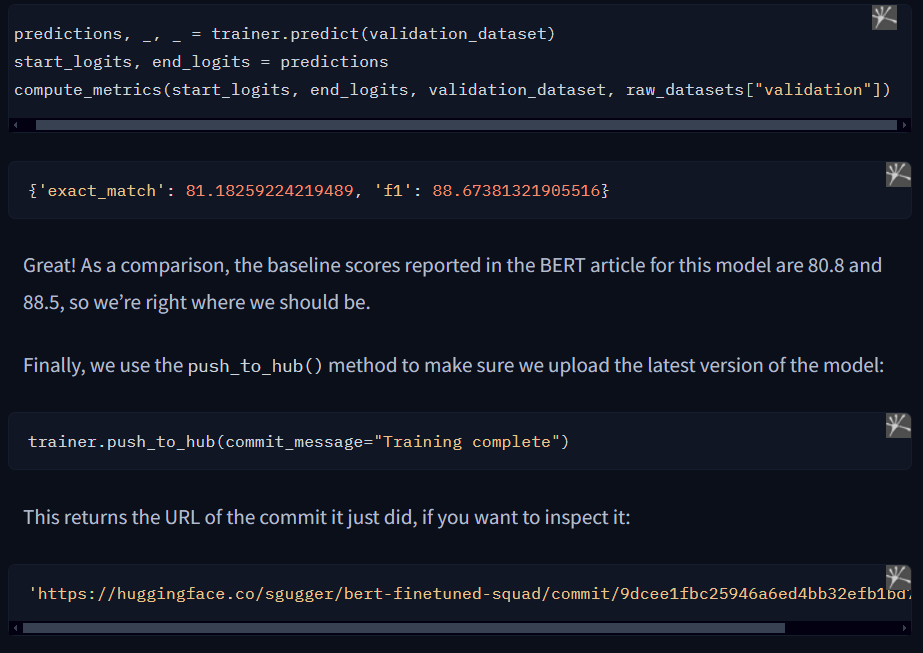

The Trainer also drafts a model card with all the evaluation results and uploads it.

At this stage, you can use the inference widget on the Model Hub to test the model and share it with your friends, family, and favorite pets. You have successfully fine-tuned a model on a question answering task — congratulations!

✏️ Your turn! Try another model architecture to see if it performs better on this task!

If you want to dive a bit more deeply into the training loop, we will now show you how to do the same thing using 🤗 Accelerate.

**A custom training loop**

Let’s now have a look at the full training loop, so you can easily customize the parts you need. with the exception of the evaluation loop. We will be able to evaluate the model regularly since we’re not constrained by the Trainer class anymore.

**Preparing everything for training**

First we need to build the DataLoaders from our datasets. We set the format of those datasets to "torch", and remove the columns in the validation set that are not used by the model. Then, we can use the default_data_collator provided by Transformers as a collate_fn and shuffle the training set, but not the validation set:

In [84]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

Next we reinstantiate our model, to make sure we’re not continuing the fine-tuning from before but starting from the BERT pretrained model again:



In [85]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Then we will need an optimizer. As usual we use the classic AdamW, which is like Adam, but with a fix in the way weight decay is applied:



In [86]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

Once we have all those objects, we can send them to the accelerator.prepare() method. Remember that if you want to train on TPUs in a Colab notebook, you will need to move all of this code into a training function, and that shouldn’t execute any cell that instantiates an Accelerator. We can force mixed-precision training by passing fp16=True to the Accelerator (or, if you are executing the code as a script, just make sure to fill in the 🤗 Accelerate config appropriately).



In [87]:
from accelerate import Accelerator

accelerator = Accelerator(fp16=True) #fp16
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

TypeError: Accelerator.__init__() got an unexpected keyword argument 'fp16'

As you should know from the previous sections, we can only use the train_dataloader length to compute the number of training steps after it has gone through the accelerator.prepare() method. We use the same linear schedule as in the previous sections:



In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

To push our model to the Hub, we will need to create a Repository object in a working folder. First log in to the Hugging Face Hub, if you’re not logged in already. We’ll determine the repository name from the model ID we want to give our model (feel free to replace the repo_name with your own choice; it just needs to contain your username, which is what the function get_full_repo_name() does):



In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

Then we can clone that repository in a local folder. If it already exists, this local folder should be a clone of the repository we are working with:



In [ ]:
We can now upload anything we save in output_dir by calling the repo.push_to_hub() method. This will help us upload the intermediate models at the end of each epoch.



**Training loop**

We are now ready to write the full training loop. After defining a progress bar to follow how training goes, the loop has three parts:

- The training in itself, which is the classic iteration over the train_dataloader, forward pass through the model, then backward pass and optimizer step.
- The evaluation, in which we gather all the values for start_logits and end_logits before converting them to NumPy arrays. Once the evaluation loop is finished, we concatenate all the results. Note that we need to truncate because the Accelerator may have added a few samples at the end to ensure we have the same number of examples in each process.
- Saving and uploading, where we first save the model and the tokenizer, then call repo.push_to_hub(). As we did before, we use the argument blocking=False to tell the 🤗 Hub library to push in an asynchronous process. This way, training continues normally and this (long) instruction is executed in the background.

Here’s the complete code for the training loop:

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In case this is the first time you’re seeing a model saved with 🤗 Accelerate, let’s take a moment to inspect the three lines of code that go with it:



In [ ]:
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

The first line is self-explanatory: it tells all the processes to wait until everyone is at that stage before continuing. This is to make sure we have the same model in every process before saving. Then we grab the unwrapped_model, which is the base model we defined. The accelerator.prepare() method changes the model to work in distributed training, so it won’t have the save_pretrained() method anymore; the accelerator.unwrap_model() method undoes that step. Lastly, we call save_pretrained() but tell that method to use accelerator.save() instead of torch.save().

Once this is done, you should have a model that produces results pretty similar to the one trained with the Trainer. You can check the model we trained using this code at huggingface-course/bert-finetuned-squad-accelerate. And if you want to test out any tweaks to the training loop, you can directly implement them by editing the code shown above!

**Using the fine-tuned model**

In [88]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

{'score': 0.9978997707366943,
 'start': 78,
 'end': 105,
 'answer': 'Jax, PyTorch and TensorFlow'}